# Bird Image Classification

*by: Ebrahim Rasromani. Starter code based on tutorial developed by Francisco Ingham and Jeremy Howard for the fast.ai [Practical Deep Learning for Coders](https://course.fast.ai/) course.*

In this project, we will attempt to predict the species of a bird represented by an image. The underlying data was obtained from the [Caltech Computer Vision group](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) and contains a total of 11,788 images of North American birds each associated with one of 200 species labels.

In [1]:
from fastai.vision import *

## Download data

In [3]:
from download import download

In [7]:
path = download('http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz', Path('data/birds'))

Replace is False and data exists, so doing nothing. Use replace==True to re-download the data.


In [19]:
import tarfile

my_tar = tarfile.open(Path('data/birds'))
my_tar.extractall(Path('data/birds_unzip'))
my_tar.close()

## View data

In [3]:
path = Path('data/birds_unzip')
path.ls()

[PosixPath('data/birds_unzip/attributes.txt'),
 PosixPath('data/birds_unzip/CUB_200_2011')]

In [4]:
path_img = path/'CUB_200_2011/images'; path_img

PosixPath('data/birds_unzip/CUB_200_2011/images')

We will need transform the collection of image data into a training and testing dataset that is compatible with a ResNet Convolutional Neural Network (CNN) architecture.

In [5]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path_img, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Now, let's take a look at the dataset!

In [11]:
data.classes

['001.Black_footed_Albatross',
 '002.Laysan_Albatross',
 '003.Sooty_Albatross',
 '004.Groove_billed_Ani',
 '005.Crested_Auklet',
 '006.Least_Auklet',
 '007.Parakeet_Auklet',
 '008.Rhinoceros_Auklet',
 '009.Brewer_Blackbird',
 '010.Red_winged_Blackbird',
 '011.Rusty_Blackbird',
 '012.Yellow_headed_Blackbird',
 '013.Bobolink',
 '014.Indigo_Bunting',
 '015.Lazuli_Bunting',
 '016.Painted_Bunting',
 '017.Cardinal',
 '018.Spotted_Catbird',
 '019.Gray_Catbird',
 '020.Yellow_breasted_Chat',
 '021.Eastern_Towhee',
 '022.Chuck_will_Widow',
 '023.Brandt_Cormorant',
 '024.Red_faced_Cormorant',
 '025.Pelagic_Cormorant',
 '026.Bronzed_Cowbird',
 '027.Shiny_Cowbird',
 '028.Brown_Creeper',
 '029.American_Crow',
 '030.Fish_Crow',
 '031.Black_billed_Cuckoo',
 '032.Mangrove_Cuckoo',
 '033.Yellow_billed_Cuckoo',
 '034.Gray_crowned_Rosy_Finch',
 '035.Purple_Finch',
 '036.Northern_Flicker',
 '037.Acadian_Flycatcher',
 '038.Great_Crested_Flycatcher',
 '039.Least_Flycatcher',
 '040.Olive_sided_Flycatcher',
 '

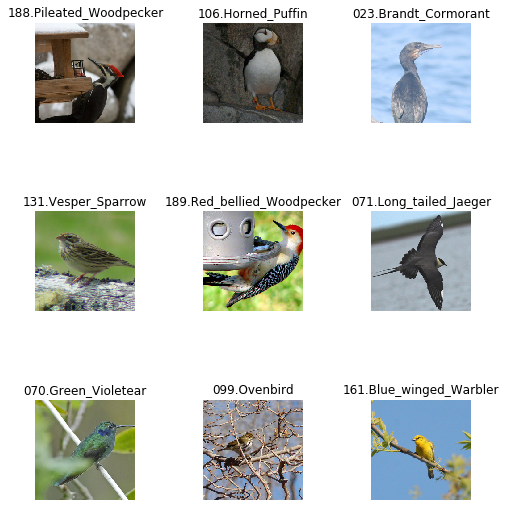

In [6]:
data.show_batch(rows=3, figsize=(7,8))

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['001.Black_footed_Albatross',
  '002.Laysan_Albatross',
  '003.Sooty_Albatross',
  '004.Groove_billed_Ani',
  '005.Crested_Auklet',
  '006.Least_Auklet',
  '007.Parakeet_Auklet',
  '008.Rhinoceros_Auklet',
  '009.Brewer_Blackbird',
  '010.Red_winged_Blackbird',
  '011.Rusty_Blackbird',
  '012.Yellow_headed_Blackbird',
  '013.Bobolink',
  '014.Indigo_Bunting',
  '015.Lazuli_Bunting',
  '016.Painted_Bunting',
  '017.Cardinal',
  '018.Spotted_Catbird',
  '019.Gray_Catbird',
  '020.Yellow_breasted_Chat',
  '021.Eastern_Towhee',
  '022.Chuck_will_Widow',
  '023.Brandt_Cormorant',
  '024.Red_faced_Cormorant',
  '025.Pelagic_Cormorant',
  '026.Bronzed_Cowbird',
  '027.Shiny_Cowbird',
  '028.Brown_Creeper',
  '029.American_Crow',
  '030.Fish_Crow',
  '031.Black_billed_Cuckoo',
  '032.Mangrove_Cuckoo',
  '033.Yellow_billed_Cuckoo',
  '034.Gray_crowned_Rosy_Finch',
  '035.Purple_Finch',
  '036.Northern_Flicker',
  '037.Acadian_Flycatcher',
  '038.Great_Crested_Flycatcher',
  '039.Least_Flycatc

## Train model: resnet34

It's time to train the model. We will start with a `resnet34` CNN architecture that has been pre-trained via the imagenet database.

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [9]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,4.639967,2.408585,0.593127,01:02
1,2.400561,1.483627,0.403479,00:50
2,1.691539,1.229204,0.338990,00:48
3,1.331682,1.080644,0.306322,00:50
4,1.050064,1.003868,0.279593,00:50
5,0.895611,0.997232,0.281714,00:48


In [10]:
learn.save('stage-1')

So far, we have not made any changes to the weights associated with the pre-trained hidden layers. By "unfreezing" those layers, we will be able to further refine the model and tailor it to our problem.

In [11]:
learn.unfreeze()

In [12]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.599987,1.138296,0.327535,00:55


In [14]:
learn.load('stage-1');

Before running additional iterations in mini-batch gradient descent, we would like to find the optimal range for the learning rate. 

*Note: `learn.fit_one_cycle()` command will utilize a cyclical learning rate which oscillates linearly between a minimum and maximum bound.*

In [15]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


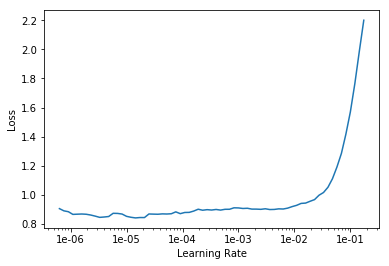

In [16]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.880384,0.968708,0.268137,00:52
1,0.825121,0.929416,0.259652,00:49
2,0.761566,0.918418,0.255409,00:50
3,0.725441,0.918403,0.254985,00:48


In [17]:
learn.save('stage-2')

After 4 epochs, the model yields an accuracy of ~75%.

## Interpretation

Let's interpret the model results to identify the source of the error.

In [12]:
learn.load('stage-2');

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

In [14]:
interp.most_confused(min_val=3)

[('051.Horned_Grebe', '050.Eared_Grebe', 7),
 ('022.Chuck_will_Widow', '105.Whip_poor_Will', 6),
 ('145.Elegant_Tern', '143.Caspian_Tern', 6),
 ('037.Acadian_Flycatcher', '043.Yellow_bellied_Flycatcher', 5),
 ('071.Long_tailed_Jaeger', '072.Pomarine_Jaeger', 4),
 ('111.Loggerhead_Shrike', '112.Great_Grey_Shrike', 4),
 ('179.Tennessee_Warbler', '173.Orange_crowned_Warbler', 4),
 ('011.Rusty_Blackbird', '009.Brewer_Blackbird', 3),
 ('031.Black_billed_Cuckoo', '033.Yellow_billed_Cuckoo', 3),
 ('040.Olive_sided_Flycatcher', '102.Western_Wood_Pewee', 3),
 ('059.California_Gull', '066.Western_Gull', 3),
 ('062.Herring_Gull', '059.California_Gull', 3),
 ('067.Anna_Hummingbird', '068.Ruby_throated_Hummingbird', 3),
 ('069.Rufous_Hummingbird', '068.Ruby_throated_Hummingbird', 3),
 ('080.Green_Kingfisher', '082.Ringed_Kingfisher', 3),
 ('096.Hooded_Oriole', '177.Prothonotary_Warbler', 3),
 ('107.Common_Raven', '029.American_Crow', 3),
 ('107.Common_Raven', '030.Fish_Crow', 3),
 ('119.Field_Sparr

It appears that the model has trouble distinguishing between related species likely due to similarity of appearance and high degree of pose and view variation.

## Training: resnet50 - low resolution

More hidden layers may be needed to perform the fine grained recognition required for distingushing the related species. We will therefore use a `resnet50` CNN architecture that has been pre-trained via the imagenet database.

In [6]:
data = ImageDataBunch.from_folder(path_img, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=128, num_workers=4).normalize(imagenet_stats)

In [7]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


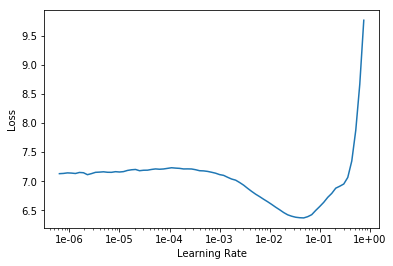

In [13]:
learn.recorder.plot()

The loss increases significantly for learning rates higher than 3e-1 hence we must select a learning rate smaller than 3e-1. We will select the learning rate at the inflection point after the loss begins to decrease as learning rate increases.

In [16]:
lr=4e-3

In [17]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,2.349283,1.844749,0.484090,01:07
1,2.018654,1.724534,0.461179,01:03
2,1.913734,1.598201,0.435723,01:04
3,1.723308,1.535328,0.420874,01:01
4,1.490893,1.409333,0.384811,01:01
5,1.295753,1.303206,0.360628,01:01
6,1.104528,1.255428,0.350021,00:58
7,0.950826,1.212756,0.331778,00:56
8,0.823113,1.203116,0.332202,00:53
9,0.787581,1.197413,0.328808,00:51


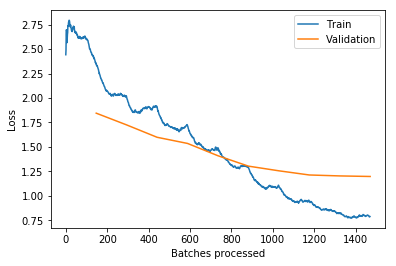

In [18]:
learn.recorder.plot_losses()

Results show signs of underfitting at the start of the learning process but the model approaches optimal capacity over time.

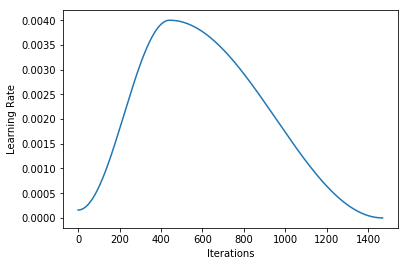

In [19]:
learn.recorder.plot_lr()

In [20]:
learn.save('stage-1-resnet50-128-epoch10')

In [21]:
learn.unfreeze()

In [30]:
learn.load('stage-1-resnet50-128-epoch10');

In [31]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


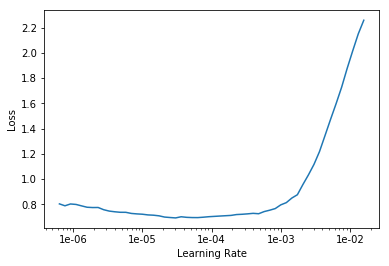

In [33]:
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(10, max_lr=slice(3e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.757629,1.189291,0.327111,00:58
1,0.741607,1.176587,0.325414,00:53
2,0.711048,1.160386,0.319050,00:53
3,0.680920,1.133076,0.312686,00:52
4,0.646490,1.112924,0.300806,00:51
5,0.556532,1.094497,0.298685,00:55
6,0.552609,1.092168,0.299109,00:54
7,0.488179,1.078203,0.294018,00:54
8,0.477539,1.081820,0.298685,00:52
9,0.475357,1.079947,0.299109,00:53


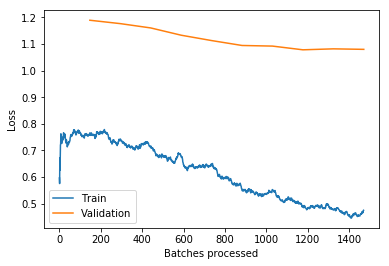

In [35]:
learn.recorder.plot_losses()

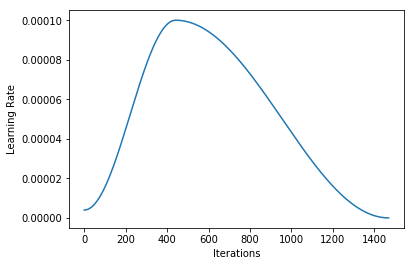

In [36]:
learn.recorder.plot_lr()

In [37]:
learn.save('stage-2-resnet50-128-epoch10')

After 10 epochs, the model yields an accuracy of ~70%. Note that this value is 5% points lower than the `resnet34` model from the prior section. The lower level of accuracy is attributed to the lower resolution images used in the `resnet50`.

## Training: resnet50 - high resolution

Using the model from the prior section as a starting point, let's increase the resolution of the images and take advantage of transfer learning to develop a more accurate model.

In [63]:
data = ImageDataBunch.from_folder(path_img, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=229, num_workers=4).normalize(imagenet_stats)

In [39]:
learn.data = data

In [11]:
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [41]:
learn.freeze()

In [42]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


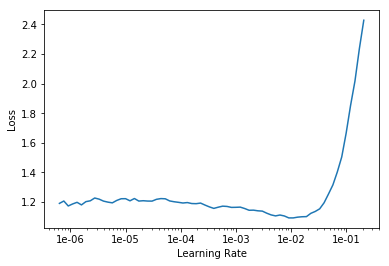

In [43]:
learn.recorder.plot()

In [46]:
lr = 1e-3

In [47]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.053401,0.570291,0.149342,01:13
1,0.913178,0.482490,0.134069,01:11
2,0.744104,0.439723,0.120492,01:12
3,0.621169,0.426904,0.125159,01:11
4,0.575619,0.427886,0.120068,01:12
5,0.508398,0.423115,0.120068,01:13
6,0.441940,0.425446,0.120916,01:11
7,0.409103,0.422978,0.120492,01:11
8,0.401152,0.420512,0.117947,01:12
9,0.382830,0.417647,0.118795,01:12


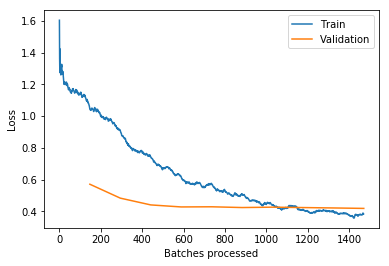

In [48]:
learn.recorder.plot_losses()

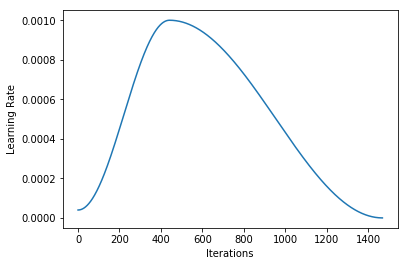

In [49]:
learn.recorder.plot_lr()

In [50]:
learn.save('stage-1-resnet50-229-epoch10')

In [51]:
learn.unfreeze()

In [52]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


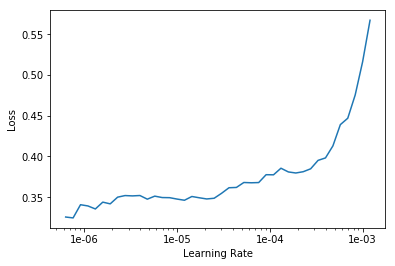

In [53]:
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(10, max_lr=slice(3e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.384505,0.417295,0.117098,01:36
1,0.370162,0.413969,0.117098,01:35
2,0.364749,0.413809,0.113280,01:35
3,0.352870,0.412663,0.115401,01:36
4,0.327033,0.407773,0.112007,01:35
5,0.317535,0.401395,0.110734,01:36
6,0.299364,0.401058,0.110734,01:35
7,0.293926,0.401356,0.116249,01:36
8,0.289311,0.399938,0.113280,01:35
9,0.285111,0.400332,0.113704,01:36


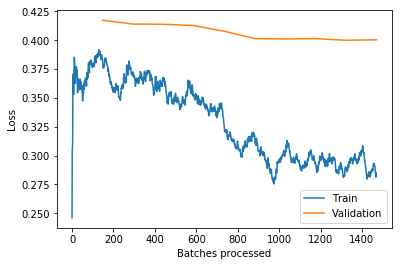

In [55]:
learn.recorder.plot_losses()

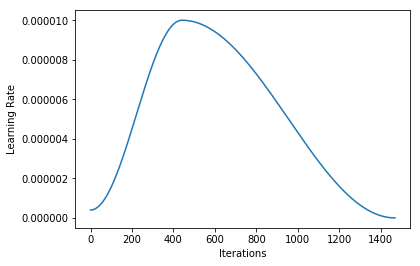

In [56]:
learn.recorder.plot_lr()

In [60]:
learn.save('stage-2-resnet50-229-epoch10');

By increasing the image resolution from 128x128 pixels to 229x229 pixels, we were able to increase the accuracy to ~89%.

## Training: resnet50 - super high resolution

Let's see if we can further increase model accuracy by increasing the input image resolution to 256x256 pixels and applying transfer learning one more time.

In [34]:
learn.load('stage-2-resnet50-229-epoch10')

Learner(data=ImageDataBunch;

Train: LabelList (9431 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
162.Canada_Warbler,162.Canada_Warbler,162.Canada_Warbler,162.Canada_Warbler,162.Canada_Warbler
Path: data/birds_unzip/CUB_200_2011/images;

Valid: LabelList (2357 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
039.Least_Flycatcher,173.Orange_crowned_Warbler,175.Pine_Warbler,112.Great_Grey_Shrike,130.Tree_Sparrow
Path: data/birds_unzip/CUB_200_2011/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      

In [35]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path_img, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=256, num_workers=4).normalize(imagenet_stats)

In [36]:
learn.data = data

In [37]:
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [38]:
learn.freeze()

In [39]:
learn.wd = 1e-3

In [40]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


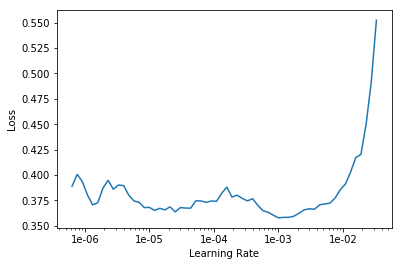

In [41]:
learn.recorder.plot()

In [42]:
lr = 6e-4

In [ ]:
learn.wd = 1e-3

In [43]:
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.398784,0.165619,0.039033,01:13
1,0.390075,0.178501,0.048791,01:13
2,0.342062,0.180373,0.050064,01:12
3,0.315396,0.181297,0.049639,01:13


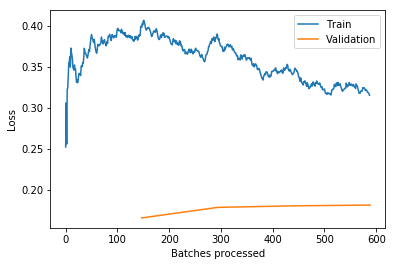

In [44]:
learn.recorder.plot_losses()

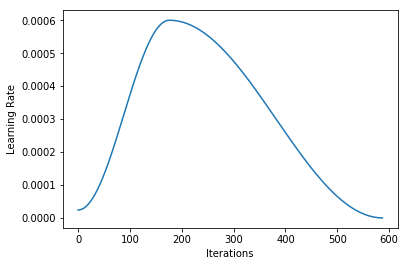

In [45]:
learn.recorder.plot_lr()

In [87]:
learn.save('stage-1-resnet50-256-epoch10')

In [88]:
learn.unfreeze()

In [89]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


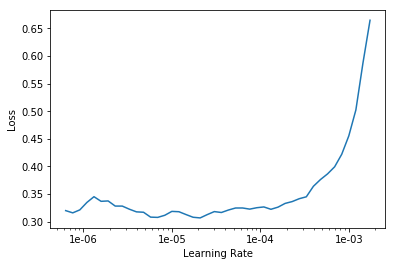

In [90]:
learn.recorder.plot()

In [91]:
learn.fit_one_cycle(10, max_lr=slice(2e-6,7e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.356513,0.166386,0.039881,01:35
1,0.338983,0.167018,0.038608,01:35
2,0.335216,0.167289,0.043275,01:36
3,0.310120,0.171872,0.042427,01:36
4,0.310178,0.173589,0.042851,01:35
5,0.291485,0.174908,0.042851,01:36
6,0.287489,0.172186,0.043275,01:35
7,0.281090,0.174061,0.042851,01:36
8,0.296236,0.172698,0.044124,01:35
9,0.280719,0.173003,0.042851,01:36


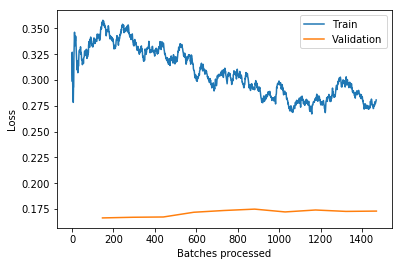

In [92]:
learn.recorder.plot_losses()

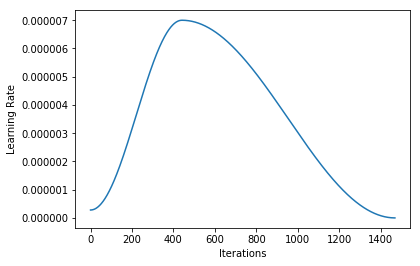

In [93]:
learn.recorder.plot_lr()

In [94]:
learn.save('stage-2-resnet50-256-epoch10')

Finally, we have developed a model with ~96% accuracy that is able to predict the species of a bird given an image. Our model results show signs of underfitting hence the model may be further improved by reducing regularization. For now, let's move on to model deployment!

## Deploy model

To deploy the model outside of the jupyter notebook (e.g. web app), we will need to export export the content of our `Learner` object for production.

In [99]:
learn.load('stage-2-resnet50-256-epoch10')

Learner(data=ImageDataBunch;

Train: LabelList (9431 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
162.Canada_Warbler,162.Canada_Warbler,162.Canada_Warbler,162.Canada_Warbler,162.Canada_Warbler
Path: data/birds_unzip/CUB_200_2011/images;

Valid: LabelList (2357 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
039.Least_Flycatcher,173.Orange_crowned_Warbler,175.Pine_Warbler,112.Great_Grey_Shrike,130.Tree_Sparrow
Path: data/birds_unzip/CUB_200_2011/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      

In [ ]:
learn.export()

For now, however, we will simply deploy the model within the jupyter notebook.

In [149]:
path = download('https://upload.wikimedia.org/wikipedia/commons/4/42/Carpodacus_purpureus_CT3.jpg', Path('data/bird_deploy/image_9'))

file_sizes:  76%|███████████████████▊      | 3.14M/4.12M [00:00<00:00, 30.0MB/s]

file_sizes: 100%|██████████████████████████| 4.12M/4.12M [00:00<00:00, 23.5MB/s]

Successfully downloaded file to data/bird_deploy/image_9


In [150]:
path = Path(path)

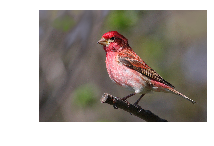

In [151]:
img = open_image(path)
img.show()

In [154]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category 035.Purple_Finch

The model correctly classifies the new bird image with the Purple Finch species category.